In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_curve, auc, classification_report, 
ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, PredictionErrorDisplay, make_scorer)
from sklearn.utils.discovery import all_displays
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import LearningCurveDisplay, learning_curve
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from pyrcn.echo_state_network import ESNClassifier

from scipy.stats import fisher_exact

from keras.models import Sequential
from keras.layers import LSTM, Dense

import torch

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

2024-04-24 00:20:01.517168: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv('/Users/michael/Documents/MA Stats/STAT 8090/final dataset/full dataset.csv')

data.head()

,Symbol,Company_Name,Exchange,Orig_Range_Low,Orig_Range_High,Price,Shares,Offer_Amount,ipo_date,IPO_Year,...,plustwo_volume_pct,plusthree_change_pct,plusthree_volume_pct,plus90_change_pct,plus90_volume_pct,plus180_change_pct,plus180_volume_pct,d1_d180,d1_pop,d1_d180_pre_price
0,KVYO,Klaviyo,NYSE,25.0,27.0,30.0,19200000,576000000,9/20/23,2023,...,0.093943,0.007383,0.130651,-0.048713,0.053359,0.022050,0.084599,0,1,1
1,CART,Maplebear,Nasdaq,26.0,28.0,30.0,22000000,660000000,9/19/23,2023,...,0.330195,-0.049430,0.202700,0.014551,0.063364,0.039052,0.193695,1,1,1
2,NMRA,Neumora Therapeutics,Nasdaq,16.0,18.0,17.0,14710000,250070000,9/15/23,2023,...,0.064895,0.063768,0.067886,-0.000683,0.013610,-0.073217,0.260952,0,0,0
3,ARM,Arm Holdings,Nasdaq,47.0,51.0,51.0,95500000,4870500000,9/14/23,2023,...,0.191713,-0.040964,0.171408,0.003058,0.073550,0.036000,0.190792,1,1,1
4,SRFM,Surf Air Mobility,NYSE,20.0,20.0,20.0,20423622,408472440,7/27/23,2023,...,0.171561,-0.204082,0.153038,0.050420,0.001763,-0.015504,0.001312,0,0,0


In [3]:
label_encoder = LabelEncoder()
data['Exchange'] = label_encoder.fit_transform(data['Exchange'])
data['Sector'] = label_encoder.fit_transform(data['Sector'])
data['Industry'] = label_encoder.fit_transform(data['Industry'])

In [4]:
data = data.drop(columns=['Symbol', 'Company_Name', 'ipo_date', 'Country_HQ', 'Pitchbook_Number',
                          'Orig_Range_Low', 'Orig_Range_High', 'Year_Founded', 'Raised_to_IPO',
                          'ipo_date_open','ipo_date_close','ipo_date_volume','plusone_open','plusone_close',
                          'plusone_volume','plustwo_open','plustwo_close','plustwo_volume','plusthree_open','plusthree_close',
                          'plusthree_volume','plus90_open','plus90_close','plus90_volume','plus180_open','plus180_close',
                          'plus180_volume','day_one_bump','ipo_date_change_pct','ipo_date_volume_pct','plusone_change_pct',
                          'plusone_volume_pct','plustwo_change_pct','plustwo_volume_pct','plusthree_change_pct',
                          'plusthree_volume_pct','plus90_change_pct','plus90_volume_pct','plus180_change_pct','plus180_volume_pct',
                          'd1_pop', 'd1_d180_pre_price'])

In [5]:
data.head()

,Exchange,Price,Shares,Offer_Amount,IPO_Year,Years_to_IPO,Price_Low_Delta,Price_High_Delta,Sector,Industry,...,market_min5,market_min4,market_min3,market_min2,market_min1,market_min0,sent_negative,sent_neutral,sent_positive,d1_d180
0,0,30.0,19200000,576000000,2023,11,0.200000,0.111111,8,79,...,15507.15789,15230.52727,15560.37143,16104.99500,15980.94783,15786.030,1,0,0,0
1,1,30.0,22000000,660000000,2023,11,0.153846,0.071429,1,53,...,12073.46421,12446.53000,13463.77810,14033.09100,13739.49652,13585.840,1,1,0,1
2,1,17.0,14710000,250070000,2023,4,0.062500,-0.055556,5,12,...,12073.46421,12446.53000,13463.77810,14033.09100,13739.49652,13585.840,0,0,0,0
3,1,51.0,95500000,4870500000,2023,33,0.085106,0.000000,8,77,...,12073.46421,12446.53000,13463.77810,14033.09100,13739.49652,13585.840,1,1,0,1
4,0,20.0,20423622,408472440,2023,12,0.000000,0.000000,6,1,...,15827.17895,15069.23478,15507.15789,15230.52727,15560.37143,16104.995,0,0,0,0


#### Echo State Network

In [6]:
X = data.drop(columns=['d1_d180'])
y = data['d1_d180']

under_sampler = RandomUnderSampler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8090)

X_train, y_train = under_sampler.fit_resample(X_train, y_train)

unique_values = set(X_train['Industry'])

# Check if at least one sample from each unique value is present in the training set
for value in unique_values:
    if value not in X_train['Industry'].unique():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8090)
        break

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid to search
param_grid = {
    'n_reservoir': [1,2,3,4,5],  # Number of reservoir units
    'spectral_radius': [0.45, 0.5, 0.55, 0.6],  # Spectral radius
    'leakage': [0.9, 0.95, 1.0],  # Leakage rate
    'solver': ['lsqr', 'ridge'],  # Solver for linear regression
    'alpha': [0.8, 0.85, 0.9, 0.95, 1.0]  # Ridge regression parameter
}

# Initialize ESN classifier
esn = ESNClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=esn, param_grid=param_grid, cv=10, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits


GridSearchCV(cv=10,
             estimator=ESNClassifier(input_to_node=InputToNode(),
                                     node_to_node=NodeToNode(),
                                     regressor=IncrementalRegression()),
             param_grid={'alpha': [0.8, 0.85, 0.9, 0.95, 1.0],
                         'leakage': [0.9, 0.95, 1.0],
                         'n_reservoir': [1, 2, 3, 4, 5],
                         'solver': ['lsqr', 'ridge'],
                         'spectral_radius': [0.45, 0.5, 0.55, 0.6]},
             scoring='accuracy', verbose=1)

In [8]:
ranks = pd.DataFrame(
    {
        'Model': grid_search.cv_results_['params'],
        'Mean Test Score': grid_search.cv_results_['mean_test_score'],
        'Std Test Score': grid_search.cv_results_['std_test_score'],
        'Rank': grid_search.cv_results_['rank_test_score']
    }
)

pd.concat([ranks.drop(['Model'], axis=1), ranks['Model'].apply(pd.Series)], axis=1).sort_values(by="Rank")

,Mean Test Score,Std Test Score,Rank,alpha,leakage,n_reservoir,solver,spectral_radius
90,0.576218,0.115824,1,0.8,1.0,2,lsqr,0.55
94,0.576218,0.115824,1,0.8,1.0,2,ridge,0.55
118,0.576218,0.115824,1,0.8,1.0,5,ridge,0.55
106,0.576218,0.115824,1,0.8,1.0,4,lsqr,0.55
110,0.576218,0.115824,1,0.8,1.0,4,ridge,0.55
...,...,...,...,...,...,...,...,...
24,0.543526,0.129730,561,0.8,0.9,4,lsqr,0.45
36,0.543526,0.129730,561,0.8,0.9,5,ridge,0.45
0,0.543526,0.129730,561,0.8,0.9,1,lsqr,0.45
4,0.543526,0.129730,561,0.8,0.9,1,ridge,0.45


In [9]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'alpha': 0.8, 'leakage': 1.0, 'n_reservoir': 1, 'solver': 'lsqr', 'spectral_radius': 0.55}


In [10]:
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test_scaled)

In [11]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5151515151515151


In [12]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
cm

Confusion Matrix:


array([[67, 60],
       [52, 52]])

In [13]:
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

odds_ratio, p_value = fisher_exact([[TP, FP], [FN, TN]])

log_odds_ratio = np.log(odds_ratio)

std_error_log_odds_ratio = np.sqrt(1/TP + 1/FP + 1/FN + 1/TN)

z_score = 1.96  # 95% confidence interval
lower_bound = log_odds_ratio - z_score * std_error_log_odds_ratio
upper_bound = log_odds_ratio + z_score * std_error_log_odds_ratio


ci_lower = np.exp(lower_bound)
ci_upper = np.exp(upper_bound)

print("95% Confidence Interval for Odds Ratio:", (ci_lower, ci_upper))
print("p-value for Odds Ratio:", p_value)

95% Confidence Interval for Odds Ratio: (0.6647012293195638, 1.8759472518516433)
p-value for Odds Ratio: 0.6933405814840801


In [14]:
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.53      0.54       127
           1       0.46      0.50      0.48       104

    accuracy                           0.52       231
   macro avg       0.51      0.51      0.51       231
weighted avg       0.52      0.52      0.52       231



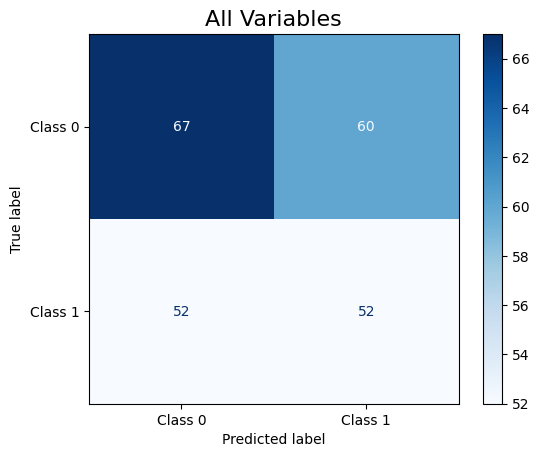

In [15]:
class_labels = ['Class 0', 'Class 1']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('All Variables', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/cm_reservoir_180.png', dpi=300, bbox_inches="tight")
plt.show()

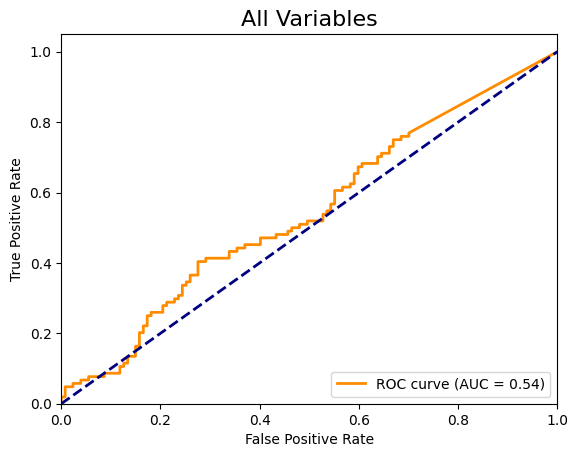

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, best_estimator.predict_proba(X_test_scaled))
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('All Variables', fontsize=16)
plt.legend(loc="lower right")
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/roc_reservoir_180.png', dpi=300, bbox_inches="tight")
plt.show()

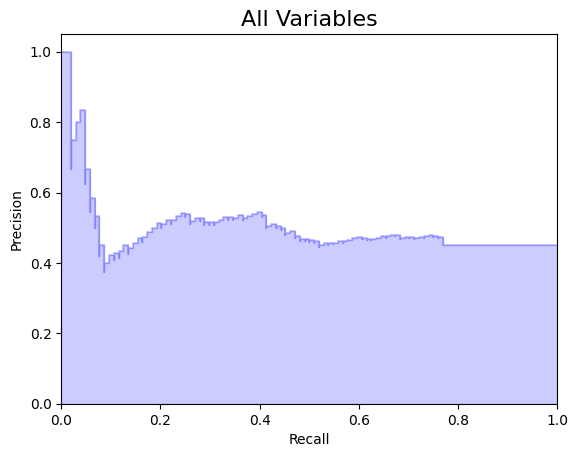

In [17]:
precision, recall, _ = precision_recall_curve(y_test, best_estimator.predict_proba(X_test_scaled))

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('All Variables', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/prc_reservoir_180.png', dpi=300, bbox_inches="tight")
plt.show()

## Feature Importance Models

### Reservior Computing

In [18]:
model = RandomForestClassifier()
model.fit(X, y)

feature_importance = pd.DataFrame(model.feature_importances_,
                                   index=X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [19]:
fi = feature_importance[feature_importance['importance'] >= 0.01]
fi = fi.index.tolist()

In [20]:
fi_data = X[fi]

In [21]:
fi_data.head()

,raise_to_ipo_ratio,90_Trailing_IPO_sub95,Years_to_IPO,Offer_Amount,Shares,Price_High_Delta,Price_Low_Delta,Price,multi_round_investors,market_min0,...,fedfund_min5,retail_sales_min6,m2_min4,retail_sales_min3,market_min4,Corporation,unrate_min4,m2_min2,retail_sales_min4,Growth/Expansion
0,0.514286,29,11,576000000,19200000,0.111111,0.200000,30.0,30,15786.030,...,4.83,594281,20829.0,600736,15230.52727,0,3.7,20789.1,599958,10
1,0.212219,28,11,660000000,22000000,0.071429,0.153846,30.0,75,13585.840,...,4.83,594281,20829.0,600736,12446.53000,0,3.7,20789.1,599958,9
2,0.290081,27,4,250070000,14710000,-0.055556,0.062500,17.0,17,13585.840,...,4.83,594281,20829.0,600736,12446.53000,0,3.7,20789.1,599958,0
3,0.931262,29,33,4870500000,95500000,0.000000,0.085106,51.0,4,13585.840,...,4.83,594281,20829.0,600736,12446.53000,16,3.7,20789.1,599958,0
4,4.129321,19,12,408472440,20423622,0.000000,0.000000,20.0,42,16104.995,...,4.57,606350,20888.1,596809,15069.23478,0,3.5,20829.0,594281,0


In [22]:
X_train, X_test, y_train, y_test = train_test_split(fi_data, y, test_size=0.3, random_state=8090)

under_sampler = RandomUnderSampler()

X_train, y_train = under_sampler.fit_resample(X_train, y_train)

unique_values = set(X_train['Industry'])

# Check if at least one sample from each unique value is present in the training set
for value in unique_values:
    if value not in X_train['Industry'].unique():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8090)
        break

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid to search
param_grid = {
    'n_reservoir': [1,2,3,4,5], 
    'spectral_radius': [0.5, 0.55, 0.6, 0.65, 0.7],  
    'leakage': [0.7, 0.8, 0.9, 0.95, 1.0],  
    'solver': ['lsqr', 'ridge'], 
    'alpha': [0.9, 0.95, 1.0, 1.05, 1.1] 
}

# Initialize ESN classifier
esn = ESNClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=esn, param_grid=param_grid, cv=10, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits


GridSearchCV(cv=10,
             estimator=ESNClassifier(input_to_node=InputToNode(),
                                     node_to_node=NodeToNode(),
                                     regressor=IncrementalRegression()),
             param_grid={'alpha': [0.8, 0.85, 0.9, 0.95, 1.0],
                         'leakage': [0.9, 0.95, 1.0],
                         'n_reservoir': [1, 2, 3, 4, 5],
                         'solver': ['lsqr', 'ridge'],
                         'spectral_radius': [0.45, 0.5, 0.55, 0.6]},
             scoring='accuracy', verbose=1)

In [24]:
ranks = pd.DataFrame(
    {
        'Model': grid_search.cv_results_['params'],
        'Mean Test Score': grid_search.cv_results_['mean_test_score'],
        'Std Test Score': grid_search.cv_results_['std_test_score'],
        'Rank': grid_search.cv_results_['rank_test_score']
    }
)

pd.concat([ranks.drop(['Model'], axis=1), ranks['Model'].apply(pd.Series)], axis=1).sort_values(by="Rank")

,Mean Test Score,Std Test Score,Rank,alpha,leakage,n_reservoir,solver,spectral_radius
483,0.590833,0.091620,1,1.0,0.9,1,lsqr,0.60
487,0.590833,0.091620,1,1.0,0.9,1,ridge,0.60
515,0.590833,0.091620,1,1.0,0.9,5,lsqr,0.60
519,0.590833,0.091620,1,1.0,0.9,5,ridge,0.60
495,0.590833,0.091620,1,1.0,0.9,2,ridge,0.60
...,...,...,...,...,...,...,...,...
88,0.532372,0.084992,591,0.8,1.0,2,lsqr,0.45
92,0.532372,0.084992,591,0.8,1.0,2,ridge,0.45
100,0.532372,0.084992,591,0.8,1.0,3,ridge,0.45
84,0.532372,0.084992,591,0.8,1.0,1,ridge,0.45


In [25]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'alpha': 1.0, 'leakage': 0.9, 'n_reservoir': 1, 'solver': 'lsqr', 'spectral_radius': 0.6}


In [26]:
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test_scaled)

In [27]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5454545454545454


In [28]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
cm

Confusion Matrix:


array([[66, 61],
       [44, 60]])

In [29]:
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

odds_ratio, p_value = fisher_exact([[TP, FP], [FN, TN]])

log_odds_ratio = np.log(odds_ratio)

std_error_log_odds_ratio = np.sqrt(1/TP + 1/FP + 1/FN + 1/TN)

z_score = 1.96  # 95% confidence interval
lower_bound = log_odds_ratio - z_score * std_error_log_odds_ratio
upper_bound = log_odds_ratio + z_score * std_error_log_odds_ratio


ci_lower = np.exp(lower_bound)
ci_upper = np.exp(upper_bound)

print("95% Confidence Interval for Odds Ratio:", (ci_lower, ci_upper))
print("p-value for Odds Ratio:", p_value)

95% Confidence Interval for Odds Ratio: (0.8753796590866646, 2.4867315133073387)
p-value for Odds Ratio: 0.14833134960430944


In [30]:
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.52      0.56       127
           1       0.50      0.58      0.53       104

    accuracy                           0.55       231
   macro avg       0.55      0.55      0.55       231
weighted avg       0.55      0.55      0.55       231



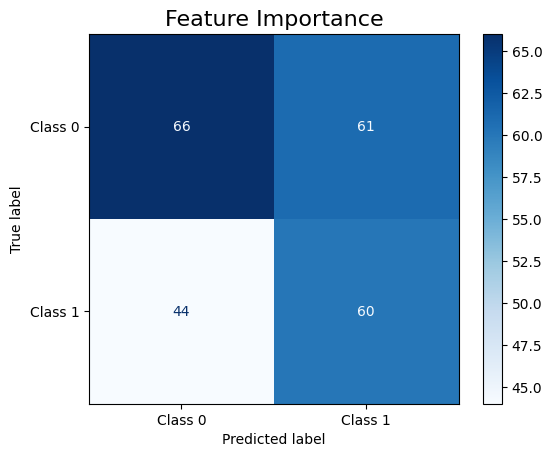

In [31]:
class_labels = ['Class 0', 'Class 1']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Feature Importance', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/cm_reservoir_180_fi.png', dpi=300, bbox_inches="tight")
plt.show()

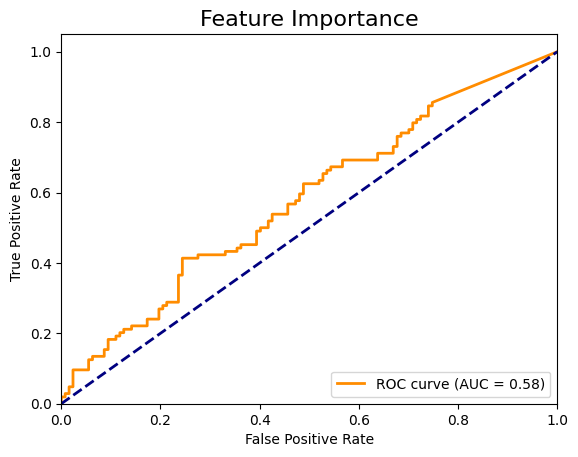

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, best_estimator.predict_proba(X_test_scaled))
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Feature Importance', fontsize=16)
plt.legend(loc="lower right")
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/roc_reservoir_180_fi.png', dpi=300, bbox_inches="tight")
plt.show()

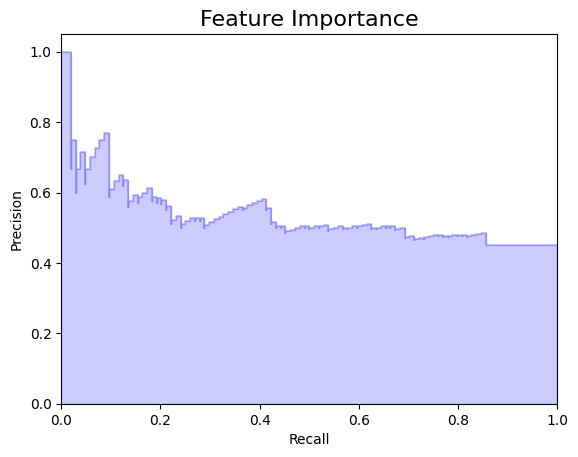

In [33]:
precision, recall, _ = precision_recall_curve(y_test, best_estimator.predict_proba(X_test_scaled))

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Feature Importance', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/prc_reservoir_180_fi.png', dpi=300, bbox_inches="tight")
plt.show()

---
### End of Notebook